# Few-shot Learning Comparison

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

import torch
from torchtext.datasets import AG_NEWS, IMDB

import flair
flair.device = torch.device('cpu')
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import numpy as np

from data.autoencoding_dataset import AutoencodingDataset
from autoencoders.autoencoder import Autoencoder

## Preparing Dataset

In [115]:
def prepare_dataset(dataset=AG_NEWS(split='test'), max_len=16):
    dr = list(dataset)
    sentences = [d[1] for d in dr]
    classes = [d[0] for d in dr]
    dp = AutoencodingDataset(sentences, classes=classes, max_len=max_len)
    dp.preproces()
    return dp

/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(


## Loading Encoder

In [116]:
def load_encoder(path, contains_loss=False):
    m = Autoencoder(100,100,100,4,3,variational=True, max_log2len=8)
    loaded = torch.load(path, map_location=torch.device('cpu'))
    loaded = loaded[0] if contains_loss else loaded

    m.load_state_dict(loaded)
    encoder = m.encoder
    return encoder

# SVM Comparison Script

In [207]:
def prepare_comparison(encoders,
                       dataset,
                       loss_functions={'acc':accuracy_score,
                                       'bacc':balanced_accuracy_score},
                       sample_size=2500,
                       rng=range(10,300,10),
                       bow=True,
                       sow=True):
  
    # Additional Encoders
    if bow:
        encoders['bow'] = (lambda x: x.mean(1))
    if sow:
        encoders['sow'] = (lambda x: x)
    
    dl = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
  
    # Preparation of the Embeddings
    print("Preparing embeddings...")
    embeddings = {k: [] for k in encoders.keys()}
    target = []
    for _, (x,y) in zip(trange(sample_size), dl):
        for k, v in embeddings.items():
            v.append(encoders[k](x).data.numpy().reshape(-1))
        target.append(y[0])#.item())
        
    for k, v in embeddings.items():
        embeddings[k] = np.array(v)
    target = (np.array(target) == np.unique(target).reshape(-1,1)).argmax(0)

    # Calculating Losses
    print("Calculating Losses...")
    
    losses = {
        k: {
            loss_name: [[] for _ in rng]
            for loss_name in loss_functions.keys()
        }
        for k in encoders.keys()
    }
    
    print(len(losses['vae']['acc']))
    
    for i, ind in enumerate(tqdm(rng)):
        
        kfold = StratifiedKFold(n_splits=sample_size//ind)
        for test_index, train_index in kfold.split(target, target):
            for encoder, embedding in embeddings.items():
                clf = SVC()
                clf.fit(embedding[train_index], target[train_index])
                pred = clf.predict(embedding[test_index])
                for loss_name, loss in loss_functions.items():
                    losses[encoder][loss_name][i].append(loss(target[test_index], pred))
        for encoder in encoders.keys():
            for loss_name in loss_functions.keys():
                losses[encoder][loss_name][i] = (
                    np.mean(losses[encoder][loss_name][i]),
                    np.std( losses[encoder][loss_name][i])
                )

    return losses

# AG_NEWS Dataset

The following is a comparison of autoencoders, where the dataset is composed of observations being subsets of the original observations of the AG_NEWS dataset with length 16.

Due to the fact, that the sequences are shortened, the Bayes error in the dataset is larger, i.e., many subsequences belonging to the a particular class may not be representative. As we will see, this shortening is enough to achieve resonably good results.

Firstly, we load pretrained autoencoders:

In [175]:
vae_encoder = load_encoder('models/ag_news/vae_epoch24.zip')
dae_encoder = load_encoder('models/ag_news/AG_NEWS_DAE_big_12epoch_new.pt', True)
vanilla_encoder = load_encoder('models/ag_news/vainlla.zip')

We load the dataset:

In [32]:
dp = prepare_dataset()

Preparing sentences...


100%|████████████████████████████████████████████████████████████████████████████| 7600/7600 [00:13<00:00, 581.22it/s]


Making sentences...


100%|███████████████████████████████████████████████████████████████████████████| 7600/7600 [00:03<00:00, 2098.26it/s]


Embedding sentences...


100%|███████████████████████████████████████████████████████████████████████████| 7600/7600 [00:01<00:00, 4241.06it/s]


Splitting sentences...


7600it [00:00, 42300.25it/s]

Done!


The comparison will calculate results for all encoders, along with bag of words approach (BOW) and stacking embeddings (SOW).

In [176]:
losses = prepare_comparison(
    {'vae':vae_encoder, 'dae':dae_encoder, 'vanilla':vanilla_encoder},
    dp,
    sample_size=2500,
    rng=range(10,300,10)
)

Preparing embeddings...


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [02:54<00:00, 14.34it/s]


Calculating Losses...
29


100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [07:09<00:00, 14.82s/it]


The results are presented below. The strong lines show the mean $\mu$ of accuracy for a particular number of labeled samples in the train dataset for few-shot learning scenario. The ribbons indicate the area between $\mu - \sigma$ and $\mu + \sigma$, where $\sigma$ is the standard deviation of the result, as calculated by cross-validation. For each number of training samples, the number of folds is maximum number of possible folds within 2500 randomly chosen observations.

Text(0, 0.5, 'Accuracy Score')

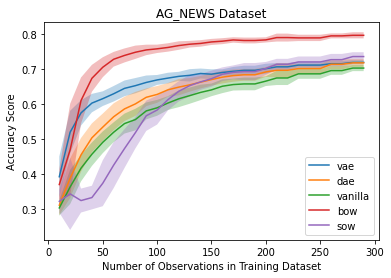

In [178]:
rng = range(10,300,10)
loss_name = 'acc'
for encoder, results in list(losses.items()):
    m, s = zip(*results[loss_name])
    m, s = np.array(m), np.array(s)
    plt.plot(rng, m, label=encoder)
    plt.fill_between(rng, m-s, m+s, alpha=0.3)
plt.legend()
plt.title("AG_NEWS Dataset")
plt.xlabel("Number of Observations in Training Dataset")
plt.ylabel("Accuracy Score")

The accuracy score indicates, that the BOW method is the best off all approaches. Unfortunately due time and hardware limitations, the encoders could not be pretrained on a larger corpus of data, which we recon would improve the accuracy of the result. Nevertheless, it is clear, that the VAE performs best of all autoencoders. The DAE is second, and the worst is the Vanilla autoencoder. The stacked embeddings is particularly bad for small number of samples manly due to the fact, that its representation is much bigger.

Importantly, as the AG_NEWS is a multiclass classification problem, it is worth to explore, if there are differences between classes. The following plot shows Balanced Accuracy Scoare for all autoencoders:

Text(0, 0.5, 'Balanced Accuracy Score')

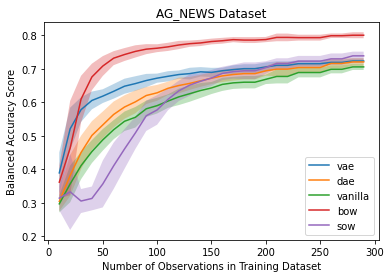

In [179]:
rng = range(10,300,10)
loss_name = 'bacc'
for encoder, results in list(losses.items()):
    m, s = zip(*results[loss_name])
    m, s = np.array(m), np.array(s)
    plt.plot(rng, m, label=encoder)
    plt.fill_between(rng, m-s, m+s, alpha=0.3)
plt.legend()
plt.title("AG_NEWS Dataset")
plt.xlabel("Number of Observations in Training Dataset")
plt.ylabel("Balanced Accuracy Score")

As we can see, the plot is very similar to the accuracy score.

## Sequence Length 128

In [203]:
vae_encoder = load_encoder('models/ag_news/vae_epoch24.zip')
dae_encoder = load_encoder('models/ag_news/AG_NEWS_DAE_big_12epoch_new.pt', True)
vanilla_encoder = load_encoder('models/ag_news/vainlla.zip')

In [202]:
dp = prepare_dataset(max_len=128)

Preparing sentences...


100%|████████████████████████████████████████████████████████████████████████████| 7600/7600 [00:10<00:00, 700.76it/s]


Making sentences...


100%|███████████████████████████████████████████████████████████████████████████| 7600/7600 [00:02<00:00, 3041.67it/s]


Embedding sentences...


100%|███████████████████████████████████████████████████████████████████████████| 7600/7600 [00:01<00:00, 5563.05it/s]


Splitting sentences...


7600it [00:00, 69085.58it/s]

Done!


# IMDB Dataset

Similarily, we compare the results for the IMDB dataset. The classification task in this case is binary. Fistly we load the data:

In [183]:
vae_encoder = load_encoder('models/imdb/vae_big_18epoch.pt', True)
dae_encoder = load_encoder('models/imdb/DAE_big_12epoch_new.pt', True)
vanilla_encoder = load_encoder('models/imdb/vanilla_epoch_10.zip')

We prepare the dataset. The dataset contains subset sequences of words of length 16, as in training of the autoencoder. As we will see, this task is more difficult for classification. 

In [ ]:
dp = prepare_dataset(IMDB(split='test'))

The comparison is being prepared:

In [198]:
losses = prepare_comparison(
    {'vae':vae_encoder, 'dae':dae_encoder, 'vanilla':vanilla_encoder},
    dp,
    sample_size=2500,
    rng=range(10,300,10),
)

Preparing embeddings...


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [01:57<00:00, 21.37it/s]


Calculating Losses...
29


100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [04:03<00:00,  8.41s/it]


And the results look as follows:

Text(0, 0.5, 'Accuracy Score')

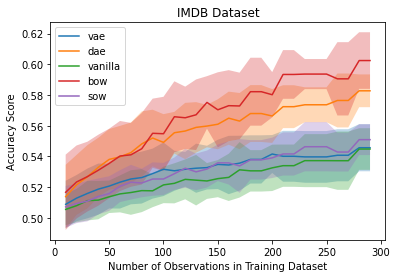

In [ ]:
rng = range(10,300,10)
loss_name = 'acc'
for encoder, results in list(losses.items()):
    m, s = zip(*results[loss_name])
    m, s = np.array(m), np.array(s)
    plt.plot(rng, m, label=encoder)
    plt.fill_between(rng, m-s, m+s, alpha=0.3)
plt.legend()
plt.title("IMDB Dataset")
plt.xlabel("Number of Observations in Training Dataset")
plt.ylabel("Accuracy Score")

As we can see, the error bands are much larger than in the previous example. The Accuracy is also particularly worse. For this task, the best autoencoder was DAE, followed by VAE and Vanilla Autoencoder, which was again the worst. However, due to large uncertainty of the result, it is difficult to say if the results can be trusted. 

Text(0, 0.5, 'Balanced Accuracy Score')

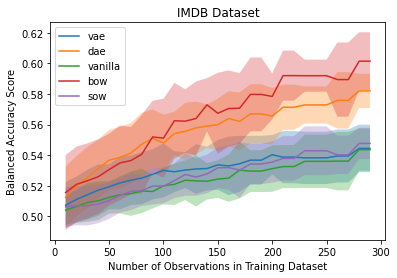

In [ ]:
rng = range(10,300,10)
loss_name = 'bacc'
for encoder, results in list(losses.items()):
    m, s = zip(*results[loss_name])
    m, s = np.array(m), np.array(s)
    plt.plot(rng, m, label=encoder)
    plt.fill_between(rng, m-s, m+s, alpha=0.3)
plt.legend()
plt.title("IMDB Dataset")
plt.xlabel("Number of Observations in Training Dataset")
plt.ylabel("Balanced Accuracy Score")

The classification is binary, so the balanced accuracy analysis is redundant here.

It is interesting to see, in this particular case, if larger portions of the original sequences will yield different results. As our method allows for sequences of arbitrary size (bounded by 128), we prepare dataset with sequences of 128. We remove the stacked embeddings from the comparison, as their representations will be very large. 

In [206]:
dp = prepare_dataset(IMDB(split='test'), max_len=128)

/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/iter/selecting.py:54: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn("Lambda function is not supported for pickle, please use "


Preparing sentences...


100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [03:51<00:00, 107.87it/s]


Making sentences...


100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [02:06<00:00, 197.76it/s]


Embedding sentences...


100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:36<00:00, 676.77it/s]


Splitting sentences...


25000it [00:01, 12802.00it/s]

Done!


The comparison is being prepared. In this case, show results only for larger mount of samples.

In [215]:
losses = prepare_comparison(
    {'vae':vae_encoder, 'dae':dae_encoder, 'vanilla':vanilla_encoder},
    dp,
    sample_size=2500,
    rng=range(200,300,10),
    sow=False
)

Preparing embeddings...


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [17:17<00:00,  2.41it/s]


Calculating Losses...
10


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.11s/it]


And the results look as follows:

Text(0, 0.5, 'Accuracy Score')

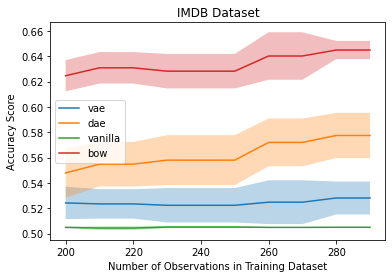

In [216]:
rng = range(200,300,10)
loss_name = 'acc'
for encoder, results in list(losses.items()):
    m, s = zip(*results[loss_name])
    m, s = np.array(m), np.array(s)
    plt.plot(rng, m, label=encoder)
    plt.fill_between(rng, m-s, m+s, alpha=0.3)
plt.legend()
plt.title("IMDB Dataset")
plt.xlabel("Number of Observations in Training Dataset")
plt.ylabel("Accuracy Score")

Notice, the obsevations range from 200 to 300 in the training dataset. The results are similar to the previous example, however they are much more certain. We can see, that the BOW performs best, and the DAE is second, much better in fact than the Vanilla and VAE. Interestingly, the Vanilla and VAE based classifiers are actually worse than in the previous example. It is perhaps due to the fact, that the encoders were trained to encode much smaller sequences. It is not an issue to the DAE autoencoder.

Text(0, 0.5, 'Balanced Accuracy Score')

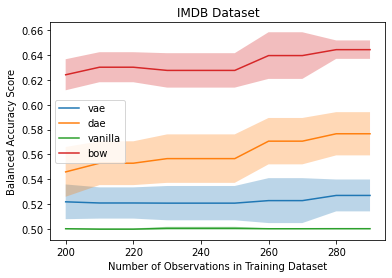

In [218]:
rng = range(200,300,10)
loss_name = 'bacc'
for encoder, results in list(losses.items()):
    m, s = zip(*results[loss_name])
    m, s = np.array(m), np.array(s)
    plt.plot(rng, m, label=encoder)
    plt.fill_between(rng, m-s, m+s, alpha=0.3)
plt.legend()
plt.title("IMDB Dataset")
plt.xlabel("Number of Observations in Training Dataset")
plt.ylabel("Balanced Accuracy Score")

The balanced accuracy looks the same, as discussed previously. 

# Discussion

The results show two important things. The VAE autoencoder, can perform well better, than both DAE and Vanilla autoencoders. The DAE has been better on the second task, however this results are less reliable. 

The second important thing is the fact, that even though the encoders achieved better scores in autoencoding task, they performed worse on the few show learning than the BOW. This is due to two things. Firstly, both tasks are relatively easy, and do not rely on deep understanding of the text, so the BOW approach can be sufficient. Secondly, the autoencoders, in particular deep autoencoders suffer from feature entanglement problem. The information about text sentiment or topic can in fact be in the embedding, however it may be more difficult to infere, especially from low number of observations. In other words, a representation is only meaningful, if we know how to read it. The autoencoders could in fact entangle the information thus making the classification task more difficult.
